# Keras Baseline Engine for VAS Challenge 2019

## Imports

In [1]:
import os
import sys
import glob
import tqdm
import keras
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
import tensorflow as tf
from matplotlib import patches
from matplotlib import pyplot as plt

# Local file import
import DftSpectrogram
import Metrics

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.logging.set_verbosity(tf.logging.ERROR)

print("Done!")

Using TensorFlow backend.


Done!


## Path to train dataset dir

In [2]:
dataset_dir = "/home/ilya/Documents/kaggle/audio/"
train_dataset_dir = os.path.join(dataset_dir, "Training_Data/")

!tree {train_dataset_dir} -L 1

/home/ilya/Documents/kaggle/audio/Training_Data/
├── human
└── spoof

2 directories, 0 files


## File paths

In [3]:
random.seed(42)

In [4]:
wav_paths = sorted(glob.glob(os.path.join(train_dataset_dir, '**/*.wav'), recursive=True))
random.shuffle(wav_paths)

train_paths = wav_paths[:40000]
dev_paths = wav_paths[40000:]

train_human  = sorted(filter(lambda path: "human" in path, train_paths))
train_spoof = sorted(filter(lambda path: "spoof" in path, train_paths))
dev_human  = sorted(filter(lambda path: "human" in path, dev_paths))
dev_spoof = sorted(filter(lambda path: "spoof" in path, dev_paths))

print("Train Human: %d" % len(train_human))
print("Train Spoof: %d" % len(train_spoof))
print("Dev   Human: %d" % len(dev_human))
print("Dev   Spoof: %d" % len(dev_spoof))

Train Human: 8256
Train Spoof: 31744
Dev   Human: 2066
Dev   Spoof: 7934


## Raw Feature Extractor 

(66000,)


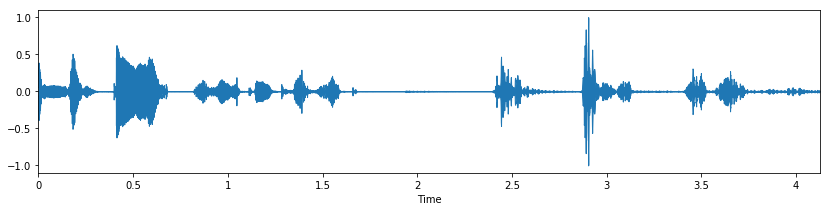

In [5]:
def get_feature(wav_path, length=66000, random_start=False):
    try:
        x, sr = librosa.load(wav_path, sr=None)
        assert sr == 16000
        if length > len(x):
            x = np.concatenate([x] * int(np.ceil(length/len(x))))
        if random_start:
            x = x[random.randint(0, len(x) - length):]
        feature = x[:length]
        return feature / np.max(np.abs(feature))
    except Exception as e:
        print("Error with getting feature from %s: %s" % (wav_path, str(e)))
        return None

feature = get_feature(random.choice(train_human), length=66000, random_start=True)
plt.figure(figsize=(14, 3))
librosa.display.waveplot(feature, sr=16000)
print(feature.shape)

## Train Data Generator

2500
(16, 66000, 1)
(16, 2)


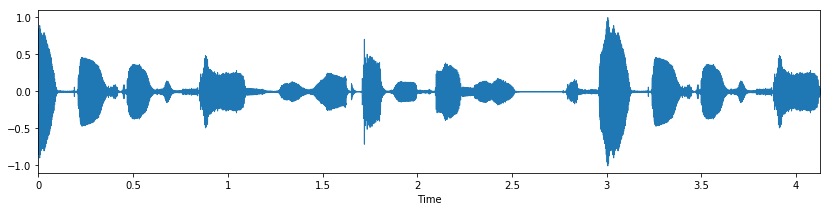

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, human_paths, spoof_paths, feature_extractor, batch_size=16):
        self.human_paths = human_paths
        self.spoof_paths = spoof_paths
        self.batch_size = batch_size
        self.feature_extractor = feature_extractor
        self.n_samples = len(self.human_paths) + len(self.spoof_paths)
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(self.n_samples / self.batch_size))
    
    def __getitem__(self, index):
        return self.data_generation()
        
    def on_epoch_end(self):
        random.shuffle(self.human_paths)
        random.shuffle(self.spoof_paths)
        
    def data_generation(self):
        wavs, labels = [], []
        while len(wavs) < self.batch_size // 2:
            wav = self.feature_extractor(random.choice(self.human_paths))
            if wav is not None:
                wavs.append(wav)
                labels.append(0)
        while len(wavs) < self.batch_size:
            wav = self.feature_extractor(random.choice(self.spoof_paths))
            if wav is not None:
                wavs.append(wav)
                labels.append(1)
        return np.stack(wavs, 0)[..., np.newaxis], keras.utils.to_categorical(np.stack(labels, 0), num_classes=2)

train_get_feature = lambda path: get_feature(path, length=66000, random_start=True)
train_data_generator = DataGenerator(train_human, train_spoof, train_get_feature, batch_size=16)
features, labels = train_data_generator[0]
plt.figure(figsize=(14, 3))
librosa.display.waveplot(features[0, ..., 0], sr=16000)
print(len(train_data_generator))
print(features.shape)
print(labels.shape)

## Dev Data Generator

10000
(1, 66000, 1)
(1, 2)


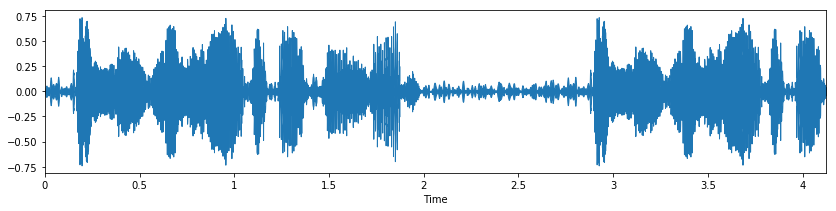

In [7]:
class DevDataGenerator(keras.utils.Sequence):
    def __init__(self, human_paths, spoof_paths, feature_extractor):
        self.human_paths = human_paths
        self.spoof_paths = spoof_paths
        self.paths = human_paths + spoof_paths
        self.labels = [0] * len(human_paths) + [1] * len(spoof_paths)
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        feature = self.feature_extractor(self.paths[index])[np.newaxis, ..., np.newaxis]
        return feature, keras.utils.to_categorical([self.labels[index]], num_classes=2)
        
dev_get_feature = lambda path: get_feature(path, length=66000, random_start=False)
dev_data_generator = DevDataGenerator(dev_human, dev_spoof, dev_get_feature)
features, labels = dev_data_generator[0]
plt.figure(figsize=(14, 3))
librosa.display.waveplot(features[0, ..., 0], sr=16000)
print(len(dev_data_generator))
print(features.shape)
print(labels.shape)

## Feature Extractor Layer

In [8]:
from matplotlib.pyplot import figure

spectrogram shape: [256, None, 1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
dft_spectrogram_1 (DftSpectr (None, 256, None, 1)      0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
(1, 256, 256, 1)


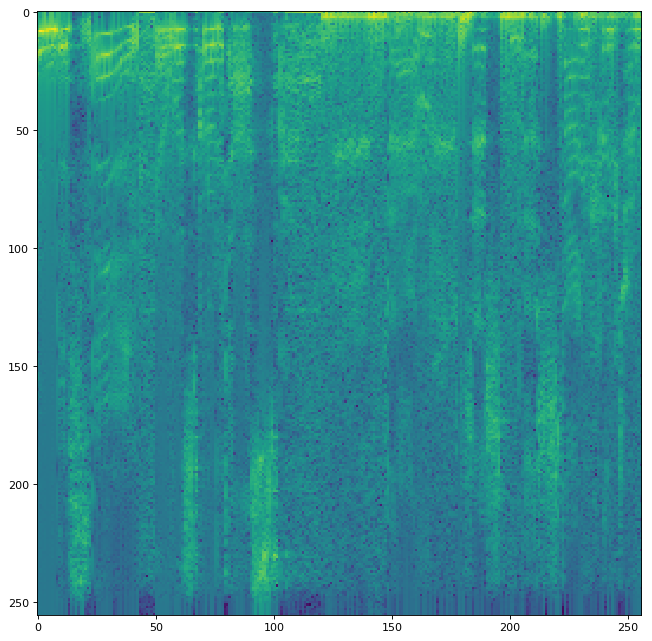

In [9]:
dft_conf = {"length": 512,
            "shift": 256,
            "nfft": 512,
            "mode": 'log',
            "normalize_feature": True}

inputs = keras.layers.Input(shape=(None, 1))
outputs = DftSpectrogram.DftSpectrogram(**dft_conf)(inputs)
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

result = model.predict(feature[np.newaxis, ..., np.newaxis])
print(result.shape)
figure(num=None, figsize=(40, 10), dpi=80,)
imgplot = plt.imshow(result[0, :, : ,0])

## Build Model

In [10]:
from keras.models import Sequential, Model
from keras.layers import (Conv2D,MaxPooling2D,Dropout,Dense,BatchNormalization,Input,Flatten, Reshape)
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler

In [11]:
def create_model(shape=result[0].shape):
    Model_input = Input(shape=shape)
    m_pooling = MaxPooling2D(4)(Model_input)
    conv = Conv2D(50, kernel_size=3, activation='relu')(m_pooling)
#     conv = Conv2D(50, kernel_size=3, activation='relu')(conv)
    b_n = BatchNormalization()(conv)
    drop = Dropout(0.1)(b_n)
    conv = Conv2D(50, kernel_size=4, activation='relu')(drop)
    m_pooling = MaxPooling2D(4)(conv)
    b_n = BatchNormalization()(m_pooling)
    drop = Dropout(0.1)(b_n)
    conv = Conv2D(50, kernel_size=4, activation='relu')(drop)
    m_pooling = MaxPooling2D(3)(conv)
#     conv = Conv2D(50, kernel_size=4, activation='relu')(m_pooling)
    b_n = BatchNormalization()(m_pooling)
    g_pooling = Conv2D(25, kernel_size=3, activation='relu')(b_n)
    out = Conv2D(2, kernel_size=(1,1), activation='softmax')(g_pooling)
    out = Reshape((2,))(out)
    model = Model(inputs=Model_input, outputs=out)
    model.summary()
    return model

mobile_net_v2 = create_model((result[0].shape))

inputs = Input(shape=(None,1))
outputs = DftSpectrogram.DftSpectrogram(**dft_conf)(inputs)

model = Model(inputs=inputs, outputs=mobile_net_v2(outputs))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 50)        500       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 50)        200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 50)        40050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 50)        0         
__________

In [61]:
mobile_net_v2 = keras.applications.mobilenet_v2.MobileNetV2(input_shape=result[0].shape, weights=None, classes=2)

inputs = keras.layers.Input(shape=(None, 1))
outputs = DftSpectrogram.DftSpectrogram(**dft_conf)(inputs)

model = keras.models.Model(inputs=inputs, outputs=mobile_net_v2(outputs))
model.summary()

spectrogram shape: [256, None, 1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, None, 1)           0         
_________________________________________________________________
dft_spectrogram_7 (DftSpectr (None, 256, None, 1)      0         
_________________________________________________________________
mobilenetv2_1.00_256 (Model) (None, 2)                 2259970   
Total params: 2,259,970
Trainable params: 2,225,858
Non-trainable params: 34,112
_________________________________________________________________


In [62]:
model.load_weights('mobile-net/model_epoch_11.h5')

In [82]:
del model.layers[-1].layers[-1]

In [90]:
model.layers[-1]

In [85]:
model.output

<tf.Tensor 'mobilenetv2_1.00_256_4/Logits/Softmax:0' shape=(?, 2) dtype=float32>

In [83]:
model.predict(features)

array([[0.9511934 , 0.04880659]], dtype=float32)

## Callbacks

In [59]:
def exp_decay(epoch, k=0.1, initial_rate=0.01):
    return initial_rate * np.exp(-k * epoch**1.4)

class Saver(keras.callbacks.Callback):
    def __init__(self, temp_models_dir):
        super().__init__()
        self.temp_models_dir = temp_models_dir
    def on_train_begin(self, logs={}):
        !mkdir -p {self.temp_models_dir}
        !rm {self.temp_models_dir}/*
    def on_epoch_end(self, epoch, logs={}):
        model.save("%s/model_epoch_%d.h5" % (self.temp_models_dir, epoch + 1))
        
class Eer(keras.callbacks.Callback):
    def __init__(self, dev_data_generator):
        super().__init__()
        self.dev_data_generator = dev_data_generator
        self.val_eers = None
    def on_train_begin(self, logs={}):
        self.val_eers = []
    def on_epoch_end(self, epoch, logs):
        results = model.predict_generator(self.dev_data_generator, verbose=1)
        human = results[:len(self.dev_data_generator.human_paths), 0]
        spoof = results[len(self.dev_data_generator.human_paths):, 0]
        val_eer = Metrics.compute_err(human, spoof)[0]
        self.val_eers.append(val_eer)
        logs["val_eer"] = val_eer
        print("%sEER = %0.3f%%" % (" "*20, val_eer))

learning_rate   = keras.callbacks.LearningRateScheduler(exp_decay)
saver           = Saver("./temp_models/")
eer             = Eer(dev_data_generator)
        
callbacks     = [learning_rate, saver, eer]
print("Total %d callbacks" % len(callbacks))

Total 3 callbacks


## Train Model

In [63]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-2, decay=0), metrics=['accuracy'])

model.fit_generator(train_data_generator,
                    steps_per_epoch = None,
                    epochs = 5,
                    callbacks = callbacks,
                    use_multiprocessing = True,
                    workers = 12,
                    )

rm: cannot remove './temp_models//*': No such file or directory
Epoch 1/5
  24/2500 [..............................] - ETA: 1:32:50 - loss: 0.0314 - acc: 0.9896

Process ForkPoolWorker-31:
Process ForkPoolWorker-26:
Process ForkPoolWorker-28:
Process ForkPoolWorker-33:
Process ForkPoolWorker-27:
Process ForkPoolWorker-34:
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ilya/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-35:
  File "/home/ilya/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ilya/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ilya/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ilya/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ilya/anaconda3/lib/python3.7/

KeyboardInterrupt: 

  File "<ipython-input-6-a2940c8acec3>", line 14, in __getitem__
    return self.data_generation()
  File "/home/ilya/.local/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "<ipython-input-6-a2940c8acec3>", line 23, in data_generation
    wav = self.feature_extractor(random.choice(self.human_paths))
  File "/home/ilya/.local/lib/python3.7/site-packages/librosa/core/audio.py", line 119, in load
    with audioread.audio_open(os.path.realpath(path)) as input_file:
  File "<ipython-input-5-75a62650b3cb>", line 3, in get_feature
    x, sr = librosa.load(wav_path, sr=None)
  File "<ipython-input-6-a2940c8acec3>", line 14, in __getitem__
    return self.data_generation()
  File "/home/ilya/.local/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "<ipython-input-6-a2940c8acec3>", line 34, in <lambda>
    train_get_feature = lambda path: get_feature

  File "/home/ilya/.local/lib/python3.7/site-packages/audioread/__init__.py", line 49, in _ca_available
    lib = ctypes.util.find_library('AudioToolbox')
  File "/home/ilya/anaconda3/lib/python3.7/ctypes/util.py", line 301, in _findLib_ld
    universal_newlines=True)
  File "/home/ilya/anaconda3/lib/python3.7/ctypes/util.py", line 122, in _findLib_gcc
    env=env)
  File "/home/ilya/.local/lib/python3.7/site-packages/audioread/ffdec.py", line 94, in popen_multiple
    return subprocess.Popen(cmd, *args, **kwargs)
  File "/home/ilya/.local/lib/python3.7/site-packages/audioread/__init__.py", line 71, in available_backends
    if _ca_available():
Process ForkPoolWorker-36:
KeyboardInterrupt
  File "/home/ilya/anaconda3/lib/python3.7/ctypes/util.py", line 332, in find_library
    _findSoname_ldconfig(name) or \
  File "/home/ilya/.local/lib/python3.7/site-packages/audioread/__init__.py", line 49, in _ca_available
    lib = ctypes.util.find_library('AudioToolbox')
KeyboardInterrupt
  File 

  File "/home/ilya/.local/lib/python3.7/site-packages/librosa/core/audio.py", line 119, in load
    with audioread.audio_open(os.path.realpath(path)) as input_file:
  File "/home/ilya/.local/lib/python3.7/site-packages/librosa/core/audio.py", line 119, in load
    with audioread.audio_open(os.path.realpath(path)) as input_file:
  File "<ipython-input-6-a2940c8acec3>", line 28, in data_generation
    wav = self.feature_extractor(random.choice(self.spoof_paths))
KeyboardInterrupt
  File "/home/ilya/.local/lib/python3.7/site-packages/audioread/__init__.py", line 107, in audio_open
    backends = available_backends()
  File "<ipython-input-6-a2940c8acec3>", line 34, in <lambda>
    train_get_feature = lambda path: get_feature(path, length=66000, random_start=True)
  File "/home/ilya/.local/lib/python3.7/site-packages/audioread/__init__.py", line 107, in audio_open
    backends = available_backends()
  File "/home/ilya/.local/lib/python3.7/site-packages/audioread/__init__.py", line 71, in a

## Load best checkpoint

In [15]:
best_checkpoint = np.argmin(eer.val_eers)
print("Best checkpoint - Epoch %d: EER = %0.3f%%" % (best_checkpoint + 1, eer.val_eers[best_checkpoint]))

model.load_weights("./temp_models/model_epoch_%d.h5" % (best_checkpoint + 1))
print("Done!")

Best checkpoint - Epoch 46: EER = 0.735%
Done!


## Save model

In [16]:
model.save("./models/baseline_model.h5")
print("Done!")

Done!


## Check single files

In [17]:
print(model.predict(dev_get_feature(random.choice(dev_human))[np.newaxis, ..., np.newaxis])[0][0])
print(model.predict(dev_get_feature(random.choice(dev_spoof))[np.newaxis, ..., np.newaxis])[0][0])

0.9999999
3.4658676e-09


## Run dev generator

In [18]:
results = model.predict_generator(dev_data_generator, verbose=1, steps=None)
print(len(results))
print(results[:5])

10000/10000 [==============================] - 41s 4ms/step
10000
[[9.9996829e-01 3.1705771e-05]
 [1.0000000e+00 2.7587401e-08]
 [9.9997389e-01 2.6144800e-05]
 [9.9999964e-01 4.1709922e-07]
 [9.9998868e-01 1.1340149e-05]]


## Metrics

2021
7979

EER = 0.735 %   @  0.939


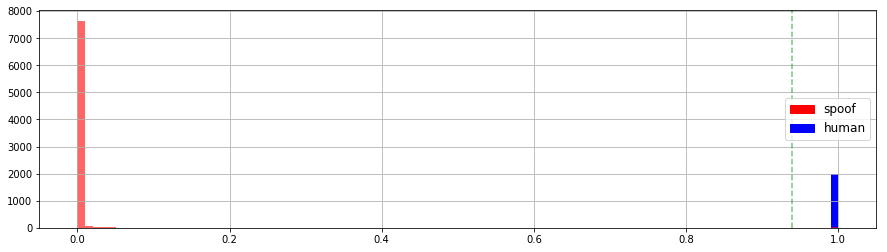

In [22]:
human = results[:len(dev_data_generator.human_paths), 0]
spoof = results[len(dev_data_generator.human_paths):, 0]

print(len(human))
print(len(spoof))

eer, threshold = Metrics.compute_err(human, spoof)

print("\nEER = %0.3f %%   @  %0.3f" % (eer, threshold))

plt.figure(figsize=(15, 4))
plt.hist(human, 99, facecolor='b', alpha=1)
plt.hist(spoof, 99, facecolor='r', alpha=0.6)
red_patch = patches.Patch(color='red', label='spoof')
blue_patch = patches.Patch(color='blue', label='human')
plt.axvline(x=threshold, linestyle='--', color='g', alpha=0.5)
plt.legend(handles=[red_patch, blue_patch], loc=5, fontsize=12)
plt.grid(True)
plt.show()

# Keras Baseline Engine for VAS Challenge 2019

In [3]:
DftSpectrogram

<module 'DftSpectrogram' from '/home/ilya/Documents/kaggle/audio/idrnd_antispoof_Baseline ID R&D/Baseline ID R&D/DftSpectrogram.py'>